In [3]:
import os
import sys

def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/MEC_Stackelberg_Project'
else:
    # 自动根据当前脚本定位项目根路径
    PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) \
        if '__file__' in globals() else os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"项目路径设置为: {PROJECT_PATH}")

项目路径设置为: c:\Users\a1831\Desktop\MEC_Stackelberg_Project


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

import src.models as models
import src.config as config
import src.run_experiment as run_experiment
import src.utils as utils
import src.algorithms.Stackelberg_solver as stackelberg_solver
import src.algorithms.user_game_solver as user_game_solver
import src.algorithms.baseline_solver as baseline_solver
import src.algorithms.previous_work as previous_work

SEED = 43

In [8]:
SWEEPER_PATH = os.path.join(PROJECT_PATH, "configs", "sweep_ce.json")
sweeper = run_experiment.ParamSweeper(SWEEPER_PATH)
configs = sweeper.sweep_configs()
print(configs)

sweep_user_provider = []
for i,config in enumerate(configs):
  users = run_experiment.create_users(config,SEED,True)
  provider = run_experiment.create_provider(config)
  sweep_user_provider.append((users,provider))

[<src.config.Config object at 0x0000021161E30310>, <src.config.Config object at 0x000002115CE25DD0>, <src.config.Config object at 0x0000021161E31C90>, <src.config.Config object at 0x0000021161E30B10>, <src.config.Config object at 0x0000021161E327D0>, <src.config.Config object at 0x0000021161E22D50>, <src.config.Config object at 0x0000021161E22C10>, <src.config.Config object at 0x0000021161DE6D10>, <src.config.Config object at 0x0000021161DE60D0>, <src.config.Config object at 0x0000021161E4FB50>, <src.config.Config object at 0x0000021161E4CED0>, <src.config.Config object at 0x0000021161E4C910>]


In [9]:
tu, tp = sweep_user_provider[0][0], sweep_user_provider[0][1]
for u in tu:
    print(u.user_id)
    u.print_user()
tp.print_providers()

0
 task: d= 0.7301091327795579  b= 51.852790828122664  alpha= 10.666954820929941
 local cpu= 1.1013962436640183
 S_i= 29.35127707894157
1
 task: d= 1.8321804261960515  b= 46.963679284405075  alpha= 10.145069122121802
 local cpu= 1.0614329830400666
 S_i= 31.75781288118785
2
 task: d= 1.0088422517197586  b= 12.09571543888293  alpha= 14.333243204496
 local cpu= 0.7212675297127461
 S_i= 29.372148451780856
3
 task: d= 0.6533253999928945  b= 68.71217798453873  alpha= 14.244695738724307
 local cpu= 1.1681416875760657
 S_i= 33.16507846717124
4
 task: d= 1.3915167216794377  b= 56.220174923970156  alpha= 10.412500248485777
 local cpu= 0.683613375817467
 S_i= 32.33279042202989
5
 task: d= 0.5102590981289139  b= 47.11058110018923  alpha= 12.377981835036266
 local cpu= 1.1360639304817615
 S_i= 32.21902523846965
6
 task: d= 2.320306151560313  b= 45.81840831971447  alpha= 10.520094749273815
 local cpu= 0.788367088370451
 S_i= 29.849340761904873
7
 task: d= 2.2300342412143634  b= 56.39676412228468  al

In [10]:
sweep_results_bnb = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
print(len(sweep_values))
print(sweep_values)

12
[0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.2, 1.5, 2, 2.2, 2.5, 3]


In [11]:
BNB_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_ce_bnb.json")
BNB_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_ce_bnb.log")

In [6]:
# 保存路径
BNB_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_ce_bnb.json")
BNB_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_ce_bnb.log")

# 如果存在 checkpoint，先读取它
if os.path.exists(BNB_JSON_PATH):
    print("📦 检测到已有结果文件，尝试恢复中...")
    with open(BNB_JSON_PATH, "r", encoding="utf-8") as f:
        sweep_results_bnb = json.load(f)
    start_index = len(sweep_results_bnb)
    print(f"🔁 已完成 {start_index}/{len(sweep_user_provider)} 个参数，准备从第 {start_index + 1} 个开始")
else:
    sweep_results_bnb = []
    start_index = 0

# 正式开始 sweep
for i in range(start_index, len(sweep_user_provider)):
    print(f"\n🌀 Running sweep {i+1}/{len(sweep_user_provider)} ...")
    try:
        users, provider = sweep_user_provider[i]
        pe_bnb, pn_bnb, X_bnb, U_bnb, results_bnb = stackelberg_solver.branch_and_bound(users, provider)

        sp_info = {
            "X": list(X_bnb),
            "U_X": U_bnb,
            "p_E": pe_bnb,
            "p_N": pn_bnb,
            "f_max": provider.f_max,
            "B_max": provider.B_max,
            "c_E": provider.c_E,
            "c_N": provider.c_N
        }

        of, ob, oc = models.ora_solver(
            [u for u in users if u.user_id in X_bnb],
            provider,
            pe_bnb,
            pn_bnb
        )

        user_game_info = {
            "f": list(of) if of is not None else 0,
            "b": list(ob) if ob is not None else 0,
            "sum_offload_cost": oc,
            "social_cost": oc+np.sum([u.cost_local() for u in users if u.user_id not in X_bnb]) if oc is not None else np.inf,
            "sum_f": np.sum(of) if of is not None else 0,
            "sum_b": np.sum(ob) if ob is not None else 0,
            "f_utilization": np.sum(of)/provider.f_max if of is not None else 0,
            "b_utilization": np.sum(ob)/provider.B_max if ob is not None else 0
        }

        user_info = [u.log_info(pe_bnb, pn_bnb) for u in users]

        res = {
            "sweep_param": sweeper.vary_param,
            "sweep_value": sweeper.values[i],
            "sp_info": sp_info,
            "user_game_info": user_game_info,
            "user_info": user_info
        }

        sweep_results_bnb.append(res)

        # 保存进度
        with open(BNB_JSON_PATH, "w", encoding="utf-8") as f:
            json.dump(sweep_results_bnb, f, ensure_ascii=False, indent=2)

        utils.log_sweep_experiments_results(sweep_results_bnb, BNB_LOG_PATH)
        print(f"✅ 完成 sweep {i+1}/{len(sweep_user_provider)}")

    except Exception as e:
        print(f"💥 第 {i+1} 个参数出错：{e}")
        continue

print("\n🏁 所有参数 sweep 完成！")


🌀 Running sweep 1/12 ...
X_init= {2}


/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:86: RuntimeWarning: invalid value encountered in sqrt
  f_thresh = ((C_l_i - C_hat_eb_i) - np.sqrt((C_l_i - C_hat_eb_i)**2 - C_hat_ef_i**2)) / (2*p_E)
/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:93: RuntimeWarning: invalid value encountered in sqrt
  B_thresh = ((C_l_i - C_hat_ef_i) - np.sqrt((C_l_i - C_hat_ef_i)**2 - C_hat_eb_i**2)) / (2*p_N)
2025-04-05 02:58:14,733 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:58:14,739 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:58:14,742 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:58:14,745 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:58:14,747 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.2281

✅ 完成 sweep 1/12

🌀 Running sweep 2/12 ...
X_init= {2}


2025-04-05 02:58:35,913 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:58:35,917 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:58:35,919 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:58:35,921 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:58:35,923 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:58:35,925 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 2/12

🌀 Running sweep 3/12 ...
X_init= {2}


2025-04-05 02:58:56,084 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:58:56,086 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:58:56,088 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:58:56,090 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:58:56,092 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:58:56,095 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 3/12

🌀 Running sweep 4/12 ...
X_init= {2}


2025-04-05 02:59:03,105 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:03,108 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:03,110 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:03,112 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:03,115 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:03,117 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 4/12

🌀 Running sweep 5/12 ...
X_init= {2}


2025-04-05 02:59:09,688 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:09,692 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:09,698 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:09,701 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:09,703 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:09,705 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 5/12

🌀 Running sweep 6/12 ...
X_init= {2}
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Iteration limit reached
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Iteration limit reached


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Iteration limit reached
Optimization failed: Positive directional derivative for linesearch


2025-04-05 02:59:30,424 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:30,427 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:30,429 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:30,431 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:30,436 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:30,438 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 6/12

🌀 Running sweep 7/12 ...
X_init= {2}
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Iteration limit reached
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positiv

2025-04-05 02:59:41,111 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:41,115 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:41,117 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:41,120 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:41,122 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:41,124 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 7/12

🌀 Running sweep 8/12 ...
X_init= {2}
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Singular matrix E in LSQ subproblem
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positi

2025-04-05 02:59:51,668 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:51,671 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:51,674 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:51,675 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:51,677 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:51,680 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 8/12

🌀 Running sweep 9/12 ...
X_init= {2}


2025-04-05 02:59:52,858 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:52,862 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:52,867 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:52,869 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:52,871 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:52,873 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 9/12

🌀 Running sweep 10/12 ...
X_init= {2}


2025-04-05 02:59:53,978 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:53,983 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:53,986 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:53,988 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:53,992 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:53,994 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 10/12

🌀 Running sweep 11/12 ...
X_init= {2}


2025-04-05 02:59:55,165 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-05 02:59:55,167 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-05 02:59:55,168 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-05 02:59:55,171 - INFO - Sweep Parameter: c_E
INFO:sweeper_logger:Sweep Parameter: c_E
2025-04-05 02:59:55,173 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 34.22816854327205,
  "p_E": 1.1914835879000003,
  "p_N": 1.0932322863700001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.1,
  "c_N": 1
}
2025-04-05 02:59:55,175 - INFO - User Game Info:
{
  "f": [

✅ 完成 sweep 11/12

🌀 Running sweep 12/12 ...
X_init= {2}


流式输出内容被截断，只能显示最后 5000 行内容。
  "B_thres": 0.7409358669654591,
  "f_hat": 4.959916159326651,
  "B_hat": 4.716832963343248
}
2025-04-05 02:59:56,451 - INFO - {
  "user id": 8,
  "task": [
    1.3088104861508152,
    79.53721945237545,
    13.678635407535603
  ],
  "S_i": 30.88551693528794,
  "local_cpu": 0.7878788423606446,
  "C_l_i": 22.72270874031366,
  "C_hat_ei": 21.64830637547169,
  "C_hat_ef_i": 9.237060706776132,
  "C_hat_eb_i": 12.411245668695559,
  "f_thres": 2.40396186839675,
  "B_thres": 3.755300742453552,
  "f_hat": 3.8762853305669656,
  "B_hat": 5.676399162115041
}
INFO:sweeper_logger:{
  "user id": 8,
  "task": [
    1.3088104861508152,
    79.53721945237545,
    13.678635407535603
  ],
  "S_i": 30.88551693528794,
  "local_cpu": 0.7878788423606446,
  "C_l_i": 22.72270874031366,
  "C_hat_ei": 21.64830637547169,
  "C_hat_ef_i": 9.237060706776132,
  "C_hat_eb_i": 12.411245668695559,
  "f_thres": 2.40396186839675,
  "B_thres": 3.755300742453552,
  "f_hat": 3.8762853305669656,
  "

✅ 完成 sweep 12/12

🏁 所有参数 sweep 完成！


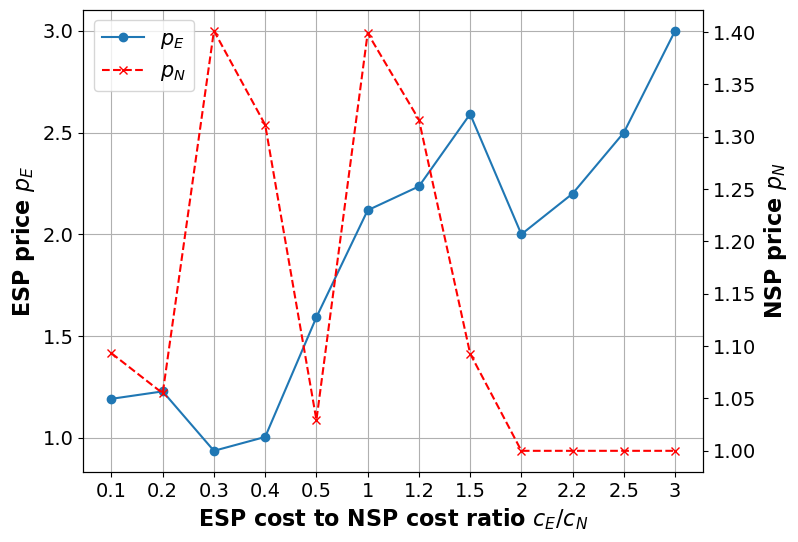

In [25]:
# 创建图和双坐标轴
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# 用于存储每个baseline绘制的Line2D对象（便于构造图例）
lines_pE = []
lines_pN = []

xvals = range(len(sweep_values))

if not os.path.exists(BNB_JSON_PATH):
    print(f"File {BNB_JSON_PATH} does not exist, skipping.")
with open(BNB_JSON_PATH, "r", encoding="utf-8") as f:
    sweep_results = json.load(f)

vals = []
pes = []
pns = []
for res in sweep_results:
    # 假设 "sweep_value" 是用户数量
    vals.append(res["sweep_value"])
    pes.append(res["sp_info"]["p_E"])
    pns.append(res["sp_info"]["p_N"])

# 对数据按用户数量排序
vals, pes = zip(*sorted(zip(vals, pes), key=lambda x: x[0]))
vals, pns = zip(*sorted(zip(vals, pns), key=lambda x: x[0]))

# 在左侧坐标轴绘制 p_E 曲线（实线）
l1, = ax1.plot(xvals, pes, marker='o', linestyle="-", label="$p_E$")
# 在右侧坐标轴绘制 p_N 曲线（虚线）
l2, = ax2.plot(xvals, pns, marker='x', linestyle="--", color='red', label="$p_N$")

lines_pE.append(l1)
lines_pN.append(l2)

# 设置 x 轴刻度，只显示10, 15, 20, 25, 30
ax1.set_xticks(xvals)
ax1.set_xticklabels(sweep_values)
ax1.set_xlabel("ESP cost to NSP cost ratio $c_E/c_N$", fontsize=16, fontweight='bold')
ax1.set_ylabel("ESP price $p_E$")
ax2.set_ylabel("NSP price $p_N$")

# 设置网格，只显示主要刻度网格
ax1.grid(True, which='major', linestyle='-', linewidth=0.8)

# 合并图例：将左侧和右侧的线对象合并，并放在图形合适位置
lines = lines_pE + lines_pN
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best',fontsize=15)

plt.rcParams.update({
    "axes.labelsize": 16,      # 坐标轴标签字体大小
    "axes.labelweight": "bold",# 坐标轴标签加粗
    "xtick.labelsize": 14,     # x轴刻度字体大小
    "ytick.labelsize": 14,     # y轴刻度字体大小
    "axes.titlesize": 16,      # 图标题字体大小
    "axes.titleweight": "bold" # 图标题加粗
})

# plt.title("The prices of ESP and NSP with")
plt.show()

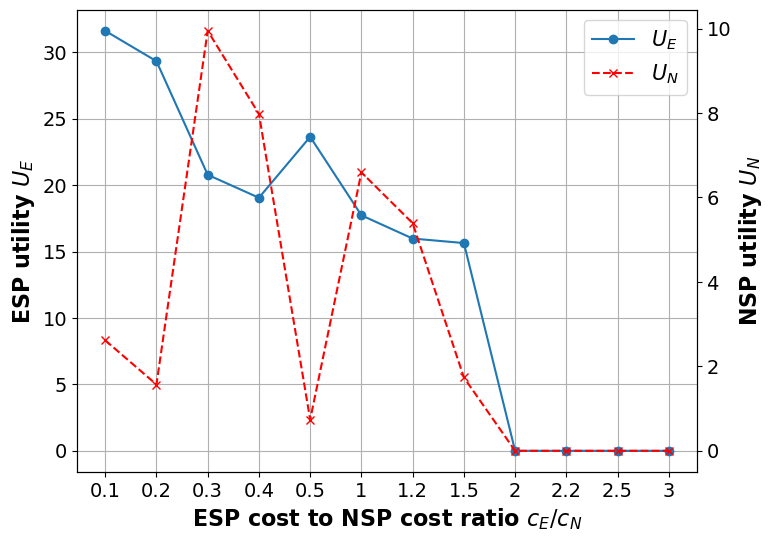

In [26]:
# 创建图和双坐标轴
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# 用于存储每个baseline绘制的Line2D对象（便于构造图例）
lines_pE = []
lines_pN = []

xvals = range(len(sweep_values))

if not os.path.exists(BNB_JSON_PATH):
    print(f"File {BNB_JSON_PATH} does not exist, skipping.")
with open(BNB_JSON_PATH, "r", encoding="utf-8") as f:
    sweep_results = json.load(f)

vals = []
ues = []
uns = []
for res in sweep_results:
    # 假设 "sweep_value" 是用户数量
    vals.append(res["sweep_value"])
    ues.append((res["sp_info"]["p_E"]-res["sp_info"]["c_E"])*res["user_game_info"]["sum_f"])
    uns.append((res["sp_info"]["p_N"]-res["sp_info"]["c_N"])*res["user_game_info"]["sum_b"])

# 对数据按用户数量排序
vals, ues = zip(*sorted(zip(vals, ues), key=lambda x: x[0]))
vals, uns = zip(*sorted(zip(vals, uns), key=lambda x: x[0]))

# 在左侧坐标轴绘制 p_E 曲线（实线）
l1, = ax1.plot(xvals, ues, marker='o', linestyle="-", label=f"$U_E$")
# 在右侧坐标轴绘制 p_N 曲线（虚线）
l2, = ax2.plot(xvals, uns, marker='x', linestyle="--", color='red', label=f"$U_N$")

lines_pE.append(l1)
lines_pN.append(l2)

# 设置 x 轴刻度，只显示10, 15, 20, 25, 30
ax1.set_xticks(xvals)
ax1.set_xticklabels(sweep_values)
ax1.set_xlabel("ESP cost to NSP cost ratio $c_E/c_N$", fontsize=16, fontweight='bold')
ax1.set_ylabel("ESP utility $U_E$")
ax2.set_ylabel("NSP utility $U_N$")

# 设置网格，只显示主要刻度网格
ax1.grid(True, which='major', linestyle='-', linewidth=0.8)

# 合并图例：将左侧和右侧的线对象合并，并放在图形合适位置
lines = lines_pE + lines_pN
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best',fontsize=15)

plt.rcParams.update({
    "axes.labelsize": 16,      # 坐标轴标签字体大小
    "axes.labelweight": "bold",# 坐标轴标签加粗
    "xtick.labelsize": 14,     # x轴刻度字体大小
    "ytick.labelsize": 14,     # y轴刻度字体大小
    "axes.titlesize": 16,      # 图标题字体大小
    "axes.titleweight": "bold" # 图标题加粗
})

# plt.title("The prices of ESP and NSP with")
plt.show()

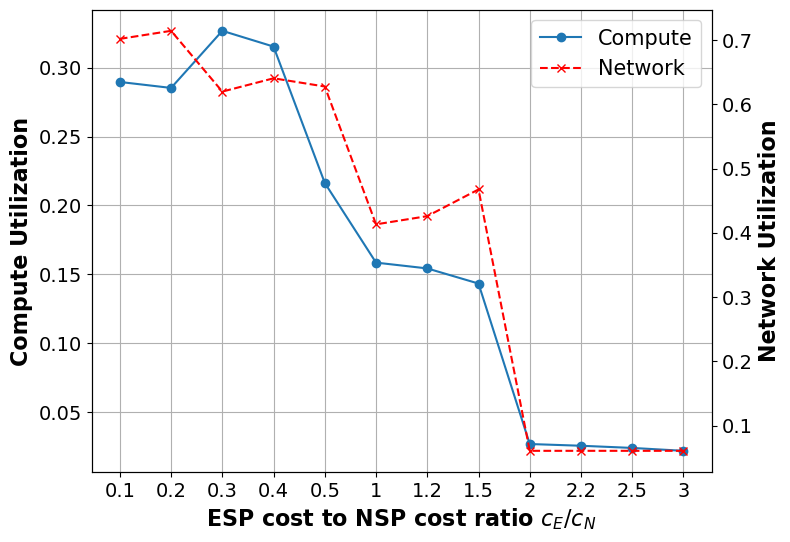

In [27]:
# 创建图和双坐标轴
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# 用于存储每个baseline绘制的Line2D对象（便于构造图例）
lines_pE = []
lines_pN = []

xvals = range(len(sweep_values))

if not os.path.exists(BNB_JSON_PATH):
    print(f"File {BNB_JSON_PATH} does not exist, skipping.")
with open(BNB_JSON_PATH, "r", encoding="utf-8") as f:
    sweep_results = json.load(f)

vals = []
futils = []
butils = []
for res in sweep_results:
    # 假设 "sweep_value" 是用户数量
    vals.append(res["sweep_value"])
    futils.append(res["user_game_info"]["f_utilization"])
    butils.append(res["user_game_info"]["b_utilization"])

# 对数据按用户数量排序
vals, futils = zip(*sorted(zip(vals, futils), key=lambda x: x[0]))
vals, butils = zip(*sorted(zip(vals, butils), key=lambda x: x[0]))

# 在左侧坐标轴绘制 p_E 曲线（实线）
l1, = ax1.plot(xvals, futils, marker='o', linestyle="-", label="Compute")
# 在右侧坐标轴绘制 p_N 曲线（虚线）
l2, = ax2.plot(xvals, butils, marker='x', linestyle="--", color='red', label="Network")

lines_pE.append(l1)
lines_pN.append(l2)

# 设置 x 轴刻度，只显示10, 15, 20, 25, 30
ax1.set_xticks(xvals)
ax1.set_xticklabels(sweep_values)
ax1.set_ylabel("Compute Utilization")
ax2.set_ylabel("Network Utilization")

ax1.set_xlabel("ESP cost to NSP cost ratio $c_E/c_N$", fontsize=16, fontweight='bold')

# 设置网格，只显示主要刻度网格
ax1.grid(True, which='major', linestyle='-', linewidth=0.8)

# 合并图例：将左侧和右侧的线对象合并，并放在图形合适位置
lines = lines_pE + lines_pN
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best',fontsize=15)

plt.rcParams.update({
    "axes.labelsize": 16,      # 坐标轴标签字体大小
    "axes.labelweight": "bold",# 坐标轴标签加粗
    "xtick.labelsize": 14,     # x轴刻度字体大小
    "ytick.labelsize": 14,     # y轴刻度字体大小
    "axes.titlesize": 16,      # 图标题字体大小
    "axes.titleweight": "bold" # 图标题加粗
})

# plt.title("The prices of ESP and NSP with")
plt.show()

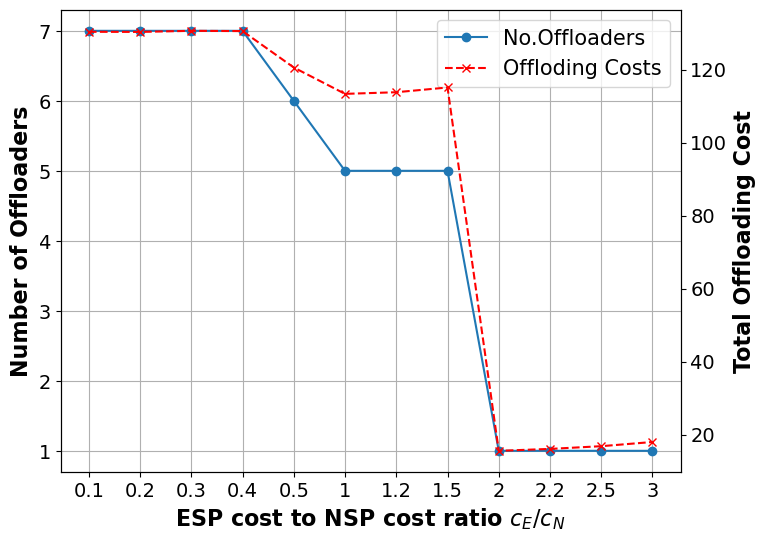

In [28]:
# 创建图和双坐标轴
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# 用于存储每个baseline绘制的Line2D对象（便于构造图例）
lines_pE = []
lines_pN = []

xvals = range(len(sweep_values))

if not os.path.exists(BNB_JSON_PATH):
    print(f"File {BNB_JSON_PATH} does not exist, skipping.")
with open(BNB_JSON_PATH, "r", encoding="utf-8") as f:
    sweep_results = json.load(f)

vals = []
no_off = []
off_cost = []
for res in sweep_results:
    # 假设 "sweep_value" 是用户数量
    vals.append(res["sweep_value"])
    no_off.append(len(res["sp_info"]["X"]))
    off_cost.append(res["user_game_info"]["sum_offload_cost"])

# 对数据按用户数量排序
vals, futils = zip(*sorted(zip(vals, no_off), key=lambda x: x[0]))
vals, butils = zip(*sorted(zip(vals, off_cost), key=lambda x: x[0]))

# 在左侧坐标轴绘制 p_E 曲线（实线）
l1, = ax1.plot(xvals, no_off, marker='o', linestyle="-", label="No.Offloaders")
# 在右侧坐标轴绘制 p_N 曲线（虚线）
l2, = ax2.plot(xvals, off_cost, marker='x', linestyle="--", color='red', label="Offloding Costs")

lines_pE.append(l1)
lines_pN.append(l2)

# 设置 x 轴刻度，只显示10, 15, 20, 25, 30
ax1.set_xticks(xvals)
ax1.set_xticklabels(sweep_values)
ax1.set_ylabel("Number of Offloaders")
ax2.set_ylabel("Total Offloading Cost")

ax1.set_xlabel("ESP cost to NSP cost ratio $c_E/c_N$", fontsize=16, fontweight='bold')

# 设置网格，只显示主要刻度网格
ax1.grid(True, which='major', linestyle='-', linewidth=0.8)

# 合并图例：将左侧和右侧的线对象合并，并放在图形合适位置
lines = lines_pE + lines_pN
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best',fontsize=15)

plt.rcParams.update({
    "axes.labelsize": 16,      # 坐标轴标签字体大小
    "axes.labelweight": "bold",# 坐标轴标签加粗
    "xtick.labelsize": 14,     # x轴刻度字体大小
    "ytick.labelsize": 14,     # y轴刻度字体大小
    "axes.titlesize": 16,      # 图标题字体大小
    "axes.titleweight": "bold" # 图标题加粗
})
# plt.title("The prices of ESP and NSP with")
plt.show()